In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from dyn_env8 import EngagementDynamics
import pickle
# from pngdataset import TrainTestDataSeperator
from easydict import EasyDict as edict

### Common variables

In [ ]:

        
        d_type = {'train':0, 'train_c':0, 'valid':1, 'test':2, 'pred':3}
        lefts = [0, 
                 int(NSamples*(sum(self.ratio[:1])/sum(self.ratio))), 
                 int(NSamples*(sum(self.ratio[:2])/sum(self.ratio))), 0]
        rights = [int(NSamples*(sum(self.ratio[:1])/sum(self.ratio))), 
                  int(NSamples*(sum(self.ratio[:2])/sum(self.ratio))), 
                  NSamples, NSamples]

In [9]:
Nsamples = 2000  # number of samples
dt = 0.01  # time step, sec
Vm_init = 300  # missile velocity magnitude, m/s
gamma_init = 45 * np.pi/180  # initial missile path angle, rad
desired_impact = -90 * np.pi/180
gammat_init = 0  # initial target path angle, rad
N = 3  # navigation constant 

### 1. Normal PNG

  0%|          | 0/2000 [00:00<?, ?it/s]

Average miss distance: 1.4670208158294271 m
Maximum miss distance: 2.9996210431798223 m
Minimum miss distance: 0.00044997084852427526 m


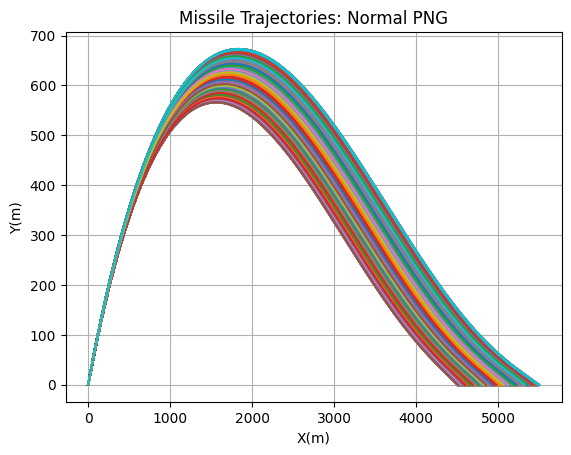

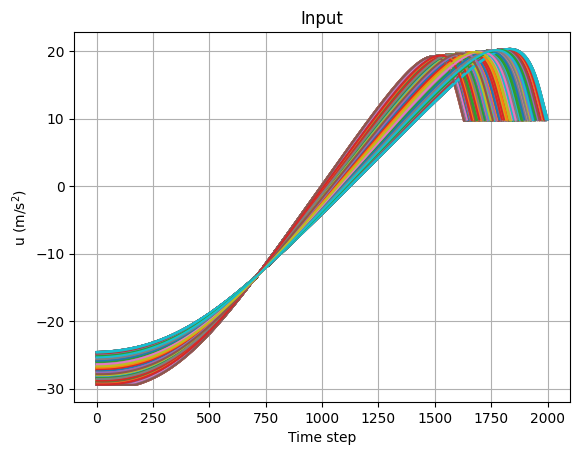

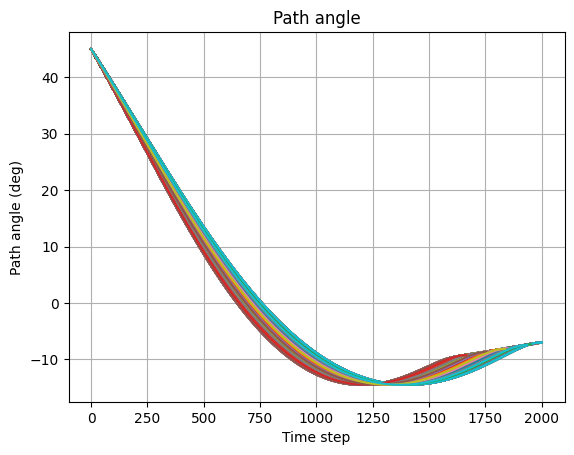

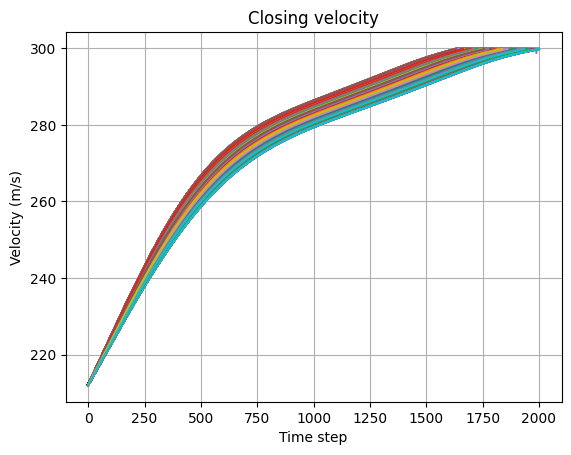

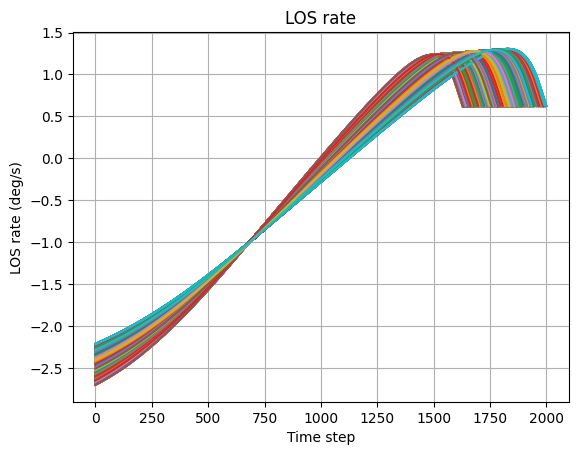

In [8]:
trajectories = [[] for i in range(Nsamples)]
inputs = [[] for i in range(Nsamples)]
missD = np.zeros(Nsamples)
closingVelocity = [[] for i in range(Nsamples)]
LOSrate = [[] for i in range(Nsamples)]
trajectories_t = [[] for i in range(Nsamples)]

for n in tqdm(range(Nsamples)):
    # initialize states 
    np.random.seed(n)  # fix seed for each sample
    target_dist = np.random.uniform(4500, 5500)  # target distance ~ uniform(a,b)
    missile_state = np.array([0, 0, Vm_init, gamma_init])
    target_state = np.array([target_dist, 0, 0, gammat_init])
    e = EngagementDynamics(missile_state, target_state, dt, desired_impact)
    xm_init = e.reset('Missile')
    xt_init = e.reset('Target')
    traj = xm_init.reshape(1,-1)
    vclose = np.array([])
    losr = np.array([])

    xm = xm_init
    xt = xt_init
    xm_prev = xm_init
    xt_prev = xt_init
    
    # normal PNG
    for i in range(10000):
        lamda_dot, R, Vc = e.estimate_LOSR(xm, xt)  # [LOS rate, range, closing velocity]
        u = e.PNG(N, Vc, lamda_dot)   # input
        
        if i == 0:  # 첫 time step일 경우 변수들 array 생성
            us = np.array(u)
            ranges = np.array(R)
            
#         elif R <= 100:  # range 30 m 이하일 경우 guidance 끔 (input = 0)
#             u = 0 

        if Vc < 0 or xm[1] < 0:  # 땅에 떨어졌을 때 오차거리 저장하고 break 
            miss_distance = np.linalg.norm(xm[0:2]-xt[0:2])
            t_end = (i+1) * dt
            break

        if xm[1] > 0:  # 만약 미사일이 고도 0m 위에 있을 경우 변수들 저장
            us = np.append(us,u)
            ranges = np.append(ranges, R)
            

        # 다음 time step의 states
        xm_new = e.RK4(xm, u)  
        xt_new = e.RK4(xt, 0)

        # 시간 업데이트
        xt_prev = xt
        xm = xm_new
        xt = xt_new
        
        

        # 미사일 state 저장 
        traj = np.append(traj, xm.reshape(1,-1), axis=0)
        vclose = np.append(vclose, Vc)
        losr = np.append(losr, lamda_dot)
        
    us = us.reshape(-1,1)
    trajectories[n] = traj
    trajectories_t[n] = target_state
    inputs[n] = us
    missD[n] = miss_distance
    closingVelocity[n] = vclose
    LOSrate[n] = losr
    
    
print('Average miss distance:', np.average(missD), 'm')
print('Maximum miss distance:', np.max(missD), 'm')
print('Minimum miss distance:', np.min(missD), 'm')

# Plot trajectories
for n in range(Nsamples):
    plt.plot(trajectories[n][:,0], trajectories[n][:,1])
plt.title('Missile Trajectories: Normal PNG')
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.grid('minor')
plt.show()

# Input
for n in range(Nsamples):
    plt.plot(inputs[n][:-1])
plt.title('Input')
plt.xlabel('Time step')  
plt.ylabel('u (m/s$^2$)')
plt.grid('minor')
plt.show()

# Path angle 
for n in range(Nsamples):
    plt.plot(trajectories[n][:,3]*180/np.pi)
plt.title('Path angle')
plt.xlabel('Time step')  
plt.ylabel('Path angle (deg)')
plt.grid('minor')
plt.show()

# Closing velocity 
for n in range(Nsamples):
    plt.plot(closingVelocity[n])
plt.title('Closing velocity')
plt.xlabel('Time step')  
plt.ylabel('Velocity (m/s)')
plt.grid('minor')
plt.show()

# LOS rate
for n in range(Nsamples):
    plt.plot(LOSrate[n][:-1]*180/np.pi)
plt.title('LOS rate')
plt.xlabel('Time step')  
plt.ylabel('LOS rate (deg/s)')
plt.grid('minor')
plt.show()

# Data saving
trajectories0 = trajectories
inputs0 = inputs
missD0 = missD
trajectories_t0 = trajectories_t

### 2. Autopilot lag

  0%|          | 0/500 [00:00<?, ?it/s]

Average miss distance: 198.1867186536477 m
Maximum miss distance: 206.91913334212296 m
Minimum miss distance: 188.18630694065752 m


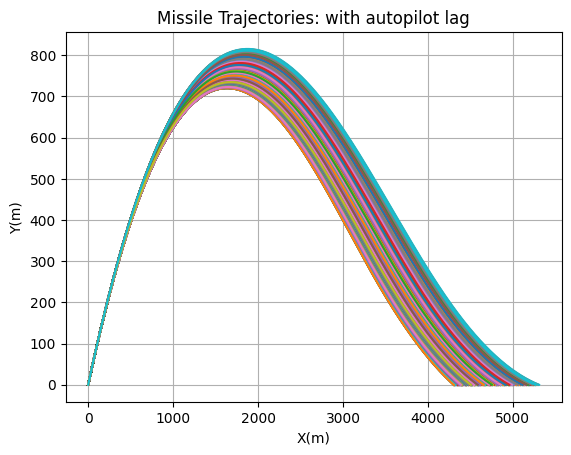

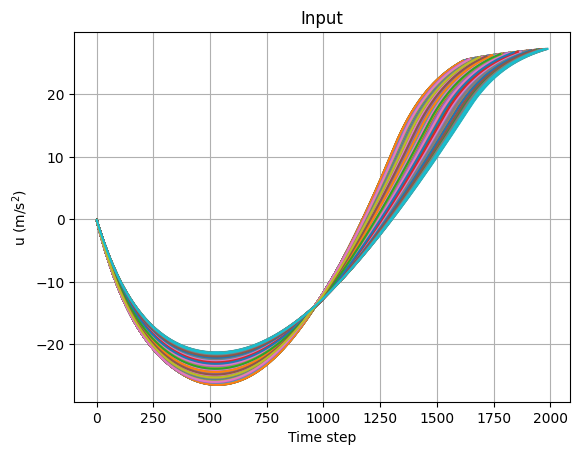

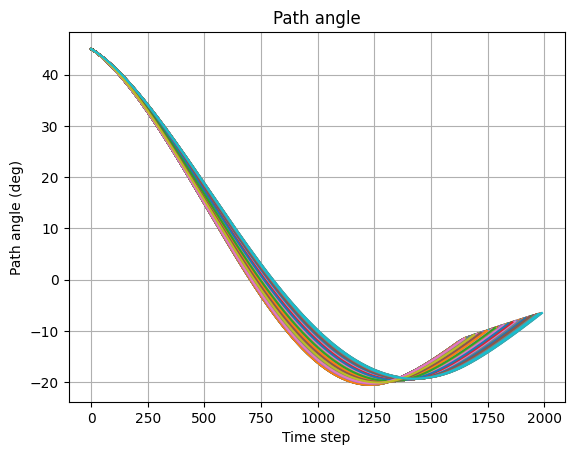

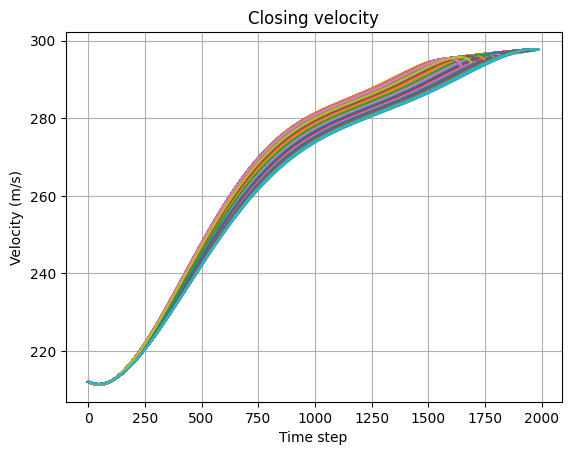

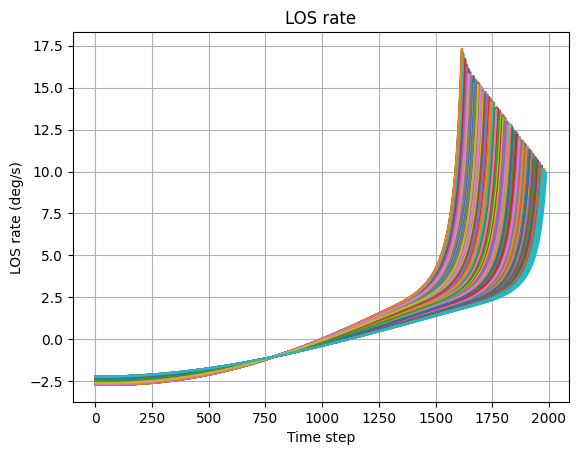

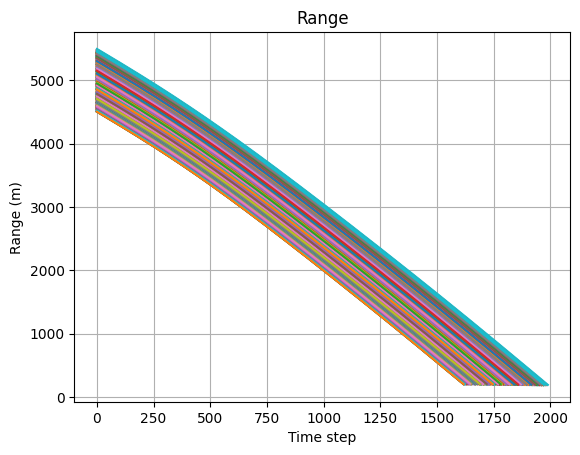

In [10]:
tau_T = 1.5 # time constant 
k = 1/tau_T

trajectories = [[] for i in range(Nsamples)]
inputs = [[] for i in range(Nsamples)]
missD = np.zeros(Nsamples)
closingVelocity = [[] for i in range(Nsamples)]
LOSrate = [[] for i in range(Nsamples)]
trajectories_t = [[] for i in range(Nsamples)]
lag = True
Ranges = [[] for i in range(Nsamples)]

for n in tqdm(range(Nsamples)):
    # initialize states 
    np.random.seed(n)
    target_dist = np.random.uniform(4500, 5500)  # target distance ~ uniform(a,b)
    missile_state = np.array([0, 0, Vm_init, gamma_init])
    target_state = np.array([target_dist, 0, 0, gammat_init])
    e = EngagementDynamics(missile_state, target_state, dt, desired_impact, k, lag)
    xm_init = e.reset('Missile')
    xt_init = e.reset('Target')
    traj = xm_init[:-1].reshape(1,-1)
    vclose = np.array([])
    losr = np.array([])
    am = np.array([])

    xm = xm_init
    xt = xt_init
    xm_prev = xm_init
    xt_prev = xt_init
    
    for i in range(10000):
        lamda_dot, R, Vc = e.estimate_LOSR(xm, xt)
        ac = e.PNG(N, Vc, lamda_dot)
    
        if i == 0:
            acs = np.array(ac)
            ranges = np.array(R)
            
#         if R <= 100:  # range 30 m 이하일 경우 guidance 끔 (input = 0)
#             ac = 0 
#             xm[5] = 0

        if Vc < 0 or xm[1] < 0:  # 땅에 떨어졌을 때 오차거리 저장하고 break 
            miss_distance = np.linalg.norm(xm[0:2]-xt[0:2])
            t_end = (i+1) * dt
            break

        if xm[1] > 0:
            acs = np.append(acs, ac)
            ranges = np.append(ranges, R)

        xm_new = e.RK4(xm, ac)  # xm = [xm, ym, vxm, vym, gamma, am]
        xt_new = e.RK4(xt, 0)

        xt_prev = xt
        xm = xm_new
        xt = xt_new
        
        

        traj = np.append(traj, xm[:-1].reshape(1,-1), axis = 0)  # u 빼고 저장 
        vclose = np.append(vclose, Vc)
        losr = np.append(losr, lamda_dot)
        am = np.append(am, xm[4])
        
  
    trajectories[n] = traj
    trajectories_t[n] = target_state
    inputs[n] = am  # 적분된 input u를 저장 
    missD[n] = miss_distance
    closingVelocity[n] = vclose
    LOSrate[n] = losr
    Ranges[n] = ranges
    
print('Average miss distance:', np.average(missD), 'm')
print('Maximum miss distance:', np.max(missD), 'm')
print('Minimum miss distance:', np.min(missD), 'm')

# Plot trajectories
for n in range(Nsamples):
    plt.plot(trajectories[n][:,0], trajectories[n][:,1])
plt.title('Missile Trajectories: with autopilot lag')
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.grid('minor')
plt.show()

# Input
for n in range(Nsamples):
    plt.plot(inputs[n][:-1])
plt.title('Input')
plt.xlabel('Time step')  
plt.ylabel('u (m/s$^2$)')
plt.grid('minor')
plt.show()

# Path angle 
for n in range(Nsamples):
    plt.plot(trajectories[n][:,3]*180/np.pi)
plt.title('Path angle')
plt.xlabel('Time step')  
plt.ylabel('Path angle (deg)')
plt.grid('minor')
plt.show()

# Closing velocity 
for n in range(Nsamples):
    plt.plot(closingVelocity[n])
plt.title('Closing velocity')
plt.xlabel('Time step')  
plt.ylabel('Velocity (m/s)')
plt.grid('minor')
plt.show()

# LOS rate
for n in range(Nsamples):
    plt.plot(LOSrate[n][:-1]*180/np.pi)
plt.title('LOS rate')
plt.xlabel('Time step')  
plt.ylabel('LOS rate (deg/s)')
plt.grid('minor')
plt.show()

# LOS rate
for n in range(Nsamples):
    plt.plot(Ranges[n])
plt.title('Range')
plt.xlabel('Time step')  
plt.ylabel('Range (m)')
plt.grid('minor')
plt.show()

# Data saving
trajectories1 = trajectories
inputs1 = inputs
missD1 = missD
trajectories_t1 = trajectories_t

### 3. LOS rate time delay

  0%|          | 0/500 [00:00<?, ?it/s]

Average miss distance: 3.837937597192188 m
Maximum miss distance: 4.848354441359583 m
Minimum miss distance: 3.091130659792086 m


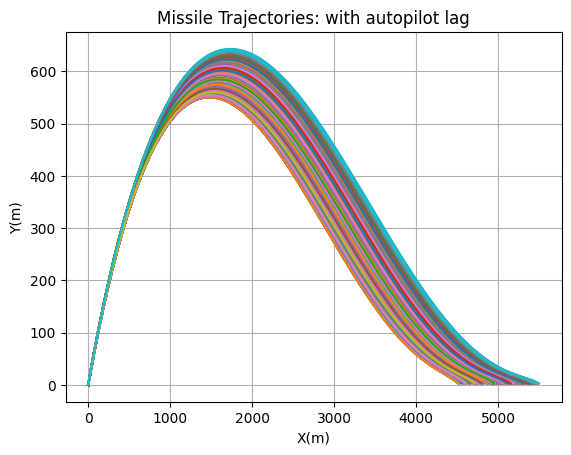

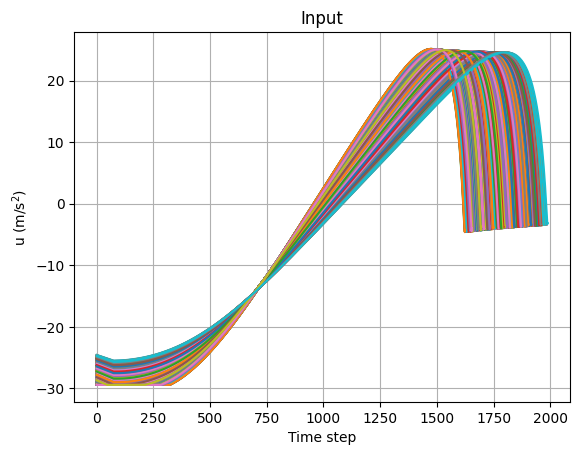

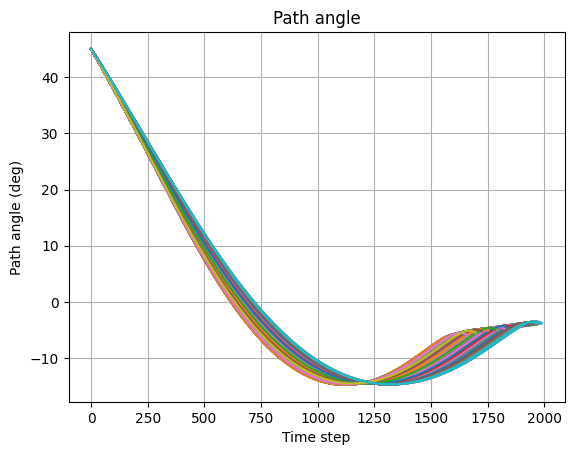

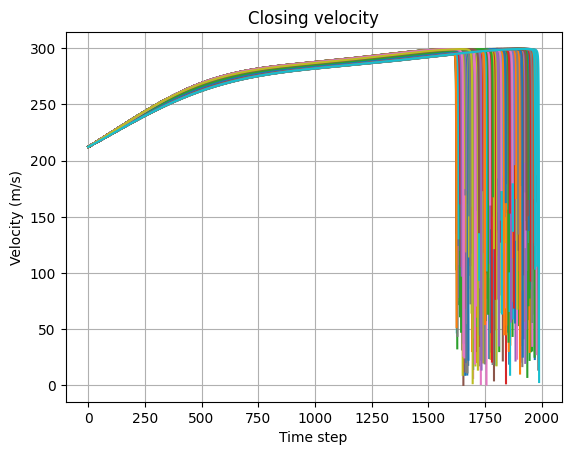

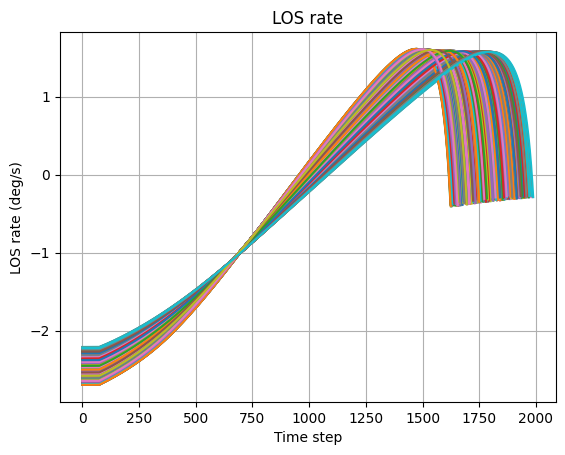

In [11]:
Time_delay = 0.75
trajectories = [[] for i in range(Nsamples)]
inputs = [[] for i in range(Nsamples)]
missD = np.zeros(Nsamples)
closingVelocity = [[] for i in range(Nsamples)]
LOSrate = [[] for i in range(Nsamples)]
trajectories_t = [[] for i in range(Nsamples)]

for n in tqdm(range(Nsamples)):
    # initialize states 
    np.random.seed(n)
    target_dist = np.random.uniform(4500, 5500)  # target distance ~ uniform(a,b)
    missile_state = np.array([0, 0, Vm_init, gamma_init])
    target_state = np.array([target_dist, 0, 0, gammat_init])
    e = EngagementDynamics(missile_state, target_state, dt, desired_impact)
    xm_init = e.reset('Missile')
    xt_init = e.reset('Target')
    traj = xm_init.reshape(1,-1)
    vclose = np.array([])
    losr = np.array([])

    xm = xm_init
    xt = xt_init
    xm_prev = xm_init
    xt_prev = xt_init
    
    for i in range(10000):
        if i < Time_delay/dt:
            lamda_dot, _, _ = e.estimate_LOSR(xm_init, xt_init)
        else:
            xm_prev = traj[-int(Time_delay/dt)]
            lamda_dot, _, _ = e.estimate_LOSR(xm_prev, xt_prev)
            
        _, R, Vc = e.estimate_LOSR(xm, xt)

        u = e.PNG(N, Vc, lamda_dot)

        if Vc < 0 or xm[1] < 0:  # 땅에 떨어졌을 때 오차거리 저장하고 break 
            miss_distance = np.linalg.norm(xm[0:2]-xt[0:2])
            t_end = (i+1) * dt
            break
            
        if i == 0:
            us = np.array(u)
            ranges = np.array(R)

        elif xm[1] > 0:
            us = np.append(us,u)
            ranges = np.append(ranges, R)

        xm_new = e.RK4(xm, u)
        xt_new = e.RK4(xt, 0)

        xt_prev = xt
        xm= xm_new
        xt = xt_new

        
        
        traj = np.append(traj, xm.reshape(1,-1), axis = 0)
        vclose = np.append(vclose, Vc)
        losr = np.append(losr, lamda_dot)
    
    us = us.reshape(-1,1) 
    trajectories[n] = traj
    inputs[n] = us
    missD[n] = miss_distance
    closingVelocity[n] = vclose
    LOSrate[n] = losr
    trajectories_t[n] = target_state
    
print('Average miss distance:', np.average(missD), 'm')
print('Maximum miss distance:', np.max(missD), 'm')
print('Minimum miss distance:', np.min(missD), 'm')

# Plot trajectories
for n in range(Nsamples):
    plt.plot(trajectories[n][:,0], trajectories[n][:,1])
plt.title('Missile Trajectories: with autopilot lag')
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.grid('minor')
plt.show()

# Input
for n in range(Nsamples):
    plt.plot(inputs[n][:-1])
plt.title('Input')
plt.xlabel('Time step')  
plt.ylabel('u (m/s$^2$)')
plt.grid('minor')
plt.show()

# Path angle 
for n in range(Nsamples):
    plt.plot(trajectories[n][:,3]*180/np.pi)
plt.title('Path angle')
plt.xlabel('Time step')  
plt.ylabel('Path angle (deg)')
plt.grid('minor')
plt.show()

# Closing velocity 
for n in range(Nsamples):
    plt.plot(closingVelocity[n])
plt.title('Closing velocity')
plt.xlabel('Time step')  
plt.ylabel('Velocity (m/s)')
plt.grid('minor')
plt.show()

# LOS rate
for n in range(Nsamples):
    plt.plot(LOSrate[n][:-1]*180/np.pi)
plt.title('LOS rate')
plt.xlabel('Time step')  
plt.ylabel('LOS rate (deg/s)')
plt.grid('minor')
plt.show()

# Data saving
trajectories3 = trajectories
inputs3 = inputs
missD3 = missD
trajectories_t3 = trajectories_t

### 4. LOS rate bias

  0%|          | 0/500 [00:00<?, ?it/s]

Average miss distance: 228.76985762029946 m
Maximum miss distance: 1659.8466213895917 m
Minimum miss distance: 0.0003684349991581844 m


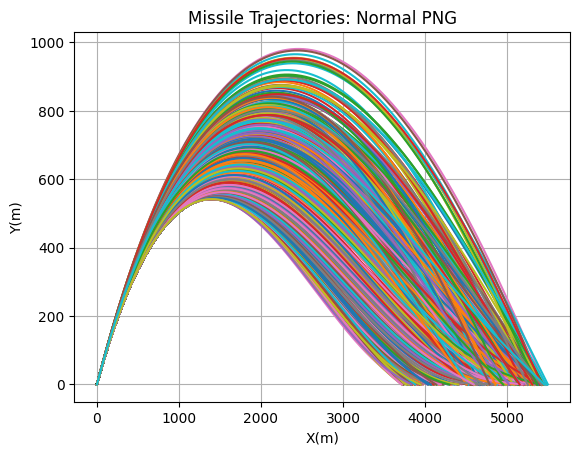

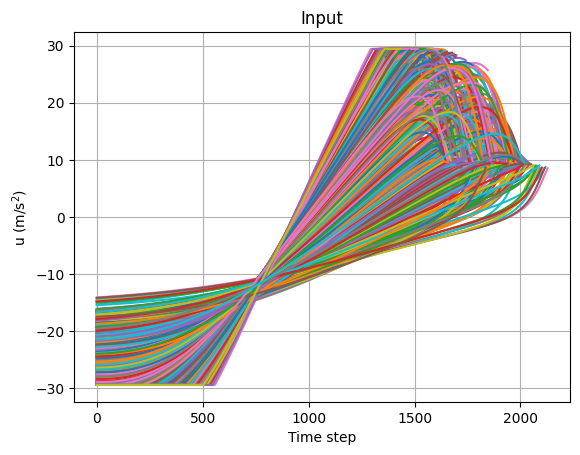

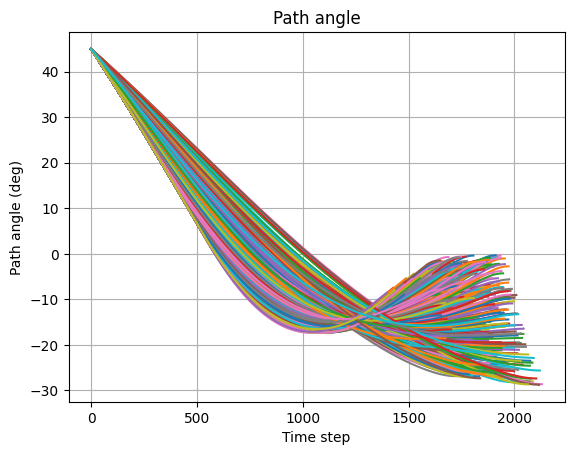

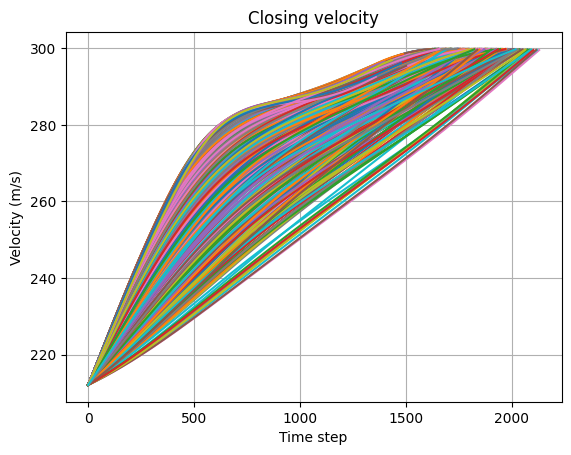

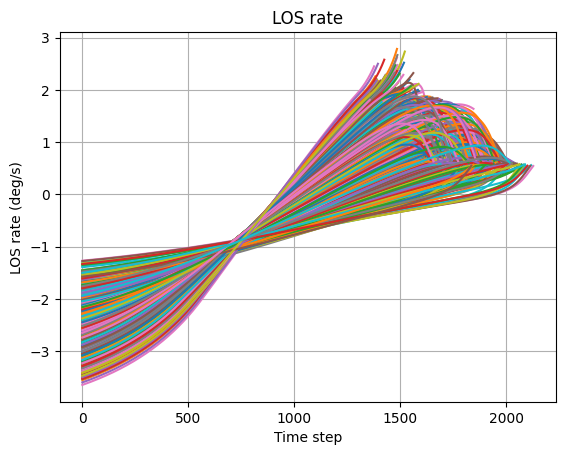

In [12]:
trajectories = [[] for i in range(Nsamples)]
inputs = [[] for i in range(Nsamples)]
missD = np.zeros(Nsamples)
closingVelocity = [[] for i in range(Nsamples)]
LOSrate = [[] for i in range(Nsamples)]
trajectories_t = [[] for i in range(Nsamples)]

for n in tqdm(range(Nsamples)):
    # initialize states 
    np.random.seed(n)  # fix seed for each sample
    target_dist = np.random.uniform(4500, 5500)  # target distance ~ uniform(a,b)
    bias_losr = np.random.uniform(-1.0, 1.0) * np.pi/180  # [a,b] deg/s bias in LOS rate
    missile_state = np.array([0, 0, Vm_init, gamma_init])
    target_state = np.array([target_dist, 0, 0, gammat_init])
    e = EngagementDynamics(missile_state, target_state, dt, desired_impact)
    xm_init = e.reset('Missile')
    xt_init = e.reset('Target')
    traj = xm_init.reshape(1,-1)
    vclose = np.array([])
    losr = np.array([])

    xm = xm_init
    xt = xt_init
    xm_prev = xm_init
    xt_prev = xt_init
    
    # normal PNG
    for i in range(10000):
        lamda_dot, R, Vc = e.estimate_LOSR(xm, xt)  # [LOS rate, range, closing velocity]
        lamda_dot += bias_losr  # LOS rate bias 추가 
        u = e.PNG(N, Vc, lamda_dot)   # input
        
        if Vc < 0 or xm[1] < 0:  # 땅에 떨어졌을 때 오차거리 저장하고 break 
            miss_distance = np.linalg.norm(xm[0:2]-xt[0:2])
            t_end = (i+1) * dt
            break

        
        if i == 0:  # 첫 time step일 경우 변수들 array 생성
            us = np.array(u)
            ranges = np.array(R)

        elif xm[1] > 0:  # 만약 미사일이 고도 0m 위에 있을 경우 변수들 저장
            us = np.append(us,u)
            ranges = np.append(ranges, R)

        # 다음 time step의 states
        xm_new = e.RK4(xm, u)  
        xt_new = e.RK4(xt, 0)

        # 시간 업데이트
        xt_prev = xt
        xm= xm_new
        xt = xt_new
        
        
        # 미사일 state 저장 
        traj = np.append(traj, xm.reshape(1,-1), axis=0)
        vclose = np.append(vclose, Vc)
        losr = np.append(losr, lamda_dot)
    
    us = us.reshape(-1,1) 
    trajectories[n] = traj
    inputs[n] = us
    missD[n] = miss_distance
    closingVelocity[n] = vclose
    LOSrate[n] = losr
    trajectories_t[n] = target_state
    
print('Average miss distance:', np.average(missD), 'm')
print('Maximum miss distance:', np.max(missD), 'm')
print('Minimum miss distance:', np.min(missD), 'm')

# Plot trajectories
for n in range(Nsamples):
    plt.plot(trajectories[n][:,0], trajectories[n][:,1])
plt.title('Missile Trajectories: Normal PNG')
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.grid('minor')
plt.show()

# Input
for n in range(Nsamples):
    plt.plot(inputs[n][:-1])
plt.title('Input')
plt.xlabel('Time step')  
plt.ylabel('u (m/s$^2$)')
plt.grid('minor')
plt.show()

# Path angle 
for n in range(Nsamples):
    plt.plot(trajectories[n][:,3]*180/np.pi)
plt.title('Path angle')
plt.xlabel('Time step')  
plt.ylabel('Path angle (deg)')
plt.grid('minor')
plt.show()

# Closing velocity 
for n in range(Nsamples):
    plt.plot(closingVelocity[n])
plt.title('Closing velocity')
plt.xlabel('Time step')  
plt.ylabel('Velocity (m/s)')
plt.grid('minor')
plt.show()

# LOS rate
for n in range(Nsamples):
    plt.plot(LOSrate[n][:-1]*180/np.pi)
plt.title('LOS rate')
plt.xlabel('Time step')  
plt.ylabel('LOS rate (deg/s)')
plt.grid('minor')
plt.show()

# Data saving
trajectories4 = trajectories
inputs4 = inputs
missD4 = missD
trajectories_t4 = trajectories_t

### Data save

In [13]:
import pickle
normal_PNG = {"states":trajectories0, "actions":inputs0, "target states":trajectories_t0, "missD": missD0, "index": 0}
autopilot_lag = {"states":trajectories1, "actions":inputs1, "target states":trajectories_t1, "missD": missD1, "index": 1}
LOSrate_delay = {"states":trajectories3, "actions":inputs3, "target states":trajectories_t3, "missD": missD3, "index": 2}
LOSrate_bias = {"states":trajectories4, "actions":inputs4, "target states":trajectories_t4, "missD": missD4, "index": 3}

unspecified_data= {"normal_PNG": normal_PNG, "autopilot_lag": autopilot_lag, 
                    "LOSrate_delay": LOSrate_delay, "LOSrate_bias": LOSrate_bias}

# save
with open('../Data/2D/Trajectories.pickle','wb') as f:
    pickle.dump(unspecified_data,f)

In [19]:
with open('./dataset/unspecified/unspecified.pickle', 'rb') as f:
    Dataset = pickle.load(f)